In [1]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from source.torch_acc import SLQDataset

from commands.experiment_7 import (
    dataset_dir,
    input_shape,
)

save_metadata_dir = "outputs/metadata/experiment_7/"

from source.labels import IMAGENET_LABELS

imshow_args = {"cmap": "jet"}

# run once
# merged_experiment_metadata = merge_experiment_metadata(save_metadata_dir=save_metadata_dir, glob_path="experiment_7_*/sl_merged_*.csv")

In [11]:
# base_path = "outputs/metadata/experiment_7/"
# for path in glob(paths):
#     newpath = "_".join(path.split("/")[-2:])
#     newpath = os.path.join(base_path, newpath)
#     # copy file from path to newpath
#     os.system(f"cp {path} {newpath}")

In [50]:
paths = os.path.join(save_metadata_dir, "*slq_merged_*.csv")
merged_data = []
for path in glob(paths):
    slq_csv = pd.read_csv(path)
    merged_data.append(slq_csv)
merged_data = pd.concat(merged_data, axis=0)


def minmax_normalize(x: np.ndarray, q=0.99):
    x[x > np.quantile(x, q=q)] = np.quantile(x, q=q)
    return (x - x.min()) / (x.max() - x.min())

In [51]:
merged_data.shape

(1400000, 7)

In [52]:
merged_data.columns

Index(['image_index', 'data_path', 'image_path', 'label', 'alpha_mask_value',
       'preds', 'q'],
      dtype='object')

In [53]:
merged_data.q.unique()

array([70, 10, 30, 50])

In [54]:
merged_data.alpha_mask_value.fillna("SL", inplace=True)
merged_data.alpha_mask_value.unique()

/tmp/ipykernel_873818/1966549322.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'SL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_data.alpha_mask_value.fillna("SL", inplace=True)


array(['SL', 0.0, 0.1, 0.2, 0.3, 0.4, 0.5], dtype=object)

In [55]:
merged_data = merged_data[merged_data.image_index<1000]

In [58]:
merged_data_acc = merged_data.groupby(["alpha_mask_value", "q"])["preds"].mean()
merged_data_acc.name = "Accuracy"
merged_data_acc = merged_data_acc.reset_index()

In [59]:
good_alphas = merged_data_acc["alpha_mask_value"].apply(
    lambda x: x in ["SL", 0.0, 0.1, 0.2]
)
merged_data_acc = merged_data_acc[good_alphas]

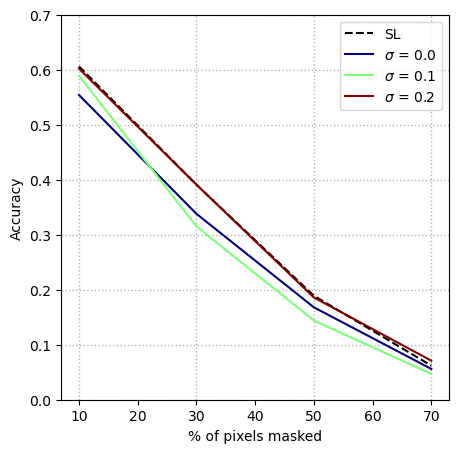

In [60]:
plt.figure(figsize=(5, 5))
# draw vertical lines at ticks
for q in merged_data_acc.q.unique():
    plt.axvline(q, linestyle=":", color="black", alpha=0.3, linewidth=1)
# draw horizontal lines at ticks
plt.ylim(0, 0.7)
ticks = plt.yticks()[0]
for acc in ticks:
    plt.axhline(
        acc,
        linestyle=":",
        color="black",
        alpha=0.3,
        linewidth=1,
    )

cmap = plt.get_cmap("jet")
color_dict = cmap(np.linspace(0, 1, len(merged_data_acc.alpha_mask_value.unique()) - 1))
merged_data_acc_SL = merged_data_acc[merged_data_acc.alpha_mask_value == "SL"]
plt.plot(
    merged_data_acc_SL.q,
    merged_data_acc_SL.Accuracy,
    label="SL",
    color="black",
    linestyle="--",
)
for i, alpha in enumerate(merged_data_acc.alpha_mask_value.unique()):
    if alpha == "SL":
        continue
    merged_data_acc_alpha_alpha = merged_data_acc[
        merged_data_acc.alpha_mask_value == alpha
    ]
    plt.plot(
        merged_data_acc_alpha_alpha.q,
        merged_data_acc_alpha_alpha.Accuracy,
        label=r"$\sigma$ = " + str(alpha),
        color=color_dict[i],
    )

# location top right
plt.legend(loc="upper right")
plt.xlabel("% of pixels masked")
plt.ylabel("Accuracy")
plt.savefig("outputs/figures/accuracy_vs_q.pdf", bbox_inches="tight")

In [61]:
merged_data_acc = merged_data.pivot_table(
    index="image_index", columns="alpha_mask_value", values="preds", aggfunc="mean"
)
merged_data_acc = merged_data_acc.drop(columns=["SL", 0.3,0.4,0.5])

In [49]:
# remove rows that have equal values for all columns
cond1 = merged_data_acc[0] == merged_data_acc[0.1]
cond2 = merged_data_acc[0] == merged_data_acc[0.2]
cond = cond1 & cond2
temp = merged_data_acc[~cond]
temp

alpha_mask_value,0.0,0.1,0.2
image_index,,,
2,0.25,0.00,0.00
4,0.00,0.25,0.25
5,0.00,0.25,0.25
7,0.50,0.50,0.75
8,0.50,0.75,0.75
...,...,...,...
49993,0.75,0.50,0.75
49994,0.50,0.75,0.50
49995,0.25,0.00,0.00


In [64]:
merged_data_acc

alpha_mask_value,0.0,0.1,0.2
image_index,,,
0,0.00,0.00,0.00
1,0.00,0.00,0.00
2,0.25,0.00,0.00
3,0.50,0.50,0.50
4,0.00,0.25,0.25
...,...,...,...
995,0.25,0.50,0.75
996,0.00,0.00,0.00
997,0.00,0.00,0.25


In [25]:
# remove sl
# for path in save_metadata_dir:
#     sl_metadata = pd.read_csv(path)
#     sl_ids = sl_metadata["alpha_mask_value"].isna()
#     rm = sl_metadata[sl_ids]["data_path"]
#     rm.apply(lambda x: os.remove(x))

In [14]:
sl_metadata = pd.read_csv(save_metadata_dir[0])
slqd = SLQDataset(sl_metadata=sl_metadata, remove_q=30, verbose=True)